# Network Traffic Anomaly Detection System

## Project Overview

This notebook details the development of a machine learning system that can detect and classify malicious network traffic. The primary goals are to:

1. **Detect Anomalies**: Identify abnormal network traffic patterns that could indicate security threats (binary classification)
2. **Classify Attack Types**: Categorize detected anomalies into specific attack categories (multi-class classification)

This two-stage approach will provide both high-level threat detection and detailed attack classification for security analysts.

## Dataset

We'll be using the UNSW-NB15 dataset, which contains both normal network traffic and various attack types. This dataset was created by the UNSW Canberra Cyber Centre and provides a modern benchmark for evaluating network intrusion detection systems.

## Development Plan

1. **Data Exploration**: Understand data structure, feature distributions, and class imbalances
2. **Feature Engineering**: Transform raw network data into meaningful features
3. **Model Selection**: Compare various algorithms to identify the best performer
4. **Hyperparameter Tuning**: Optimize model parameters using Optuna
5. **Model Evaluation**: Comprehensive assessment of model performance
6. **Deployment Strategy**: Create a simple API for model integration

Let's begin!

## Required Libraries

First, we'll import all the necessary libraries for our analysis and modeling.

In [5]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import pickle
import os

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Gradient boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# Hyperparameter optimization
import optuna


# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 17

## 1. Data Loading and Exploration

Let's start by loading the UNSW-NB15 dataset and exploring its characteristics.

In [23]:
# Configure paths based on repository structure
REPO_ROOT = '..'  # Adjust if needed
DATA_DIR = os.path.join(REPO_ROOT, 'data/UNSW_NB15_data')
MODELS_DIR = os.path.join(REPO_ROOT, 'models/UNSW_NB15_models')

# Define specific paths
train_path = os.path.join(DATA_DIR, 'UNSW_NB15_training-set.parquet')
test_path = os.path.join(DATA_DIR, 'UNSW_NB15_testing-set.parquet')

# Load the datasets
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (175341, 36)
Testing data shape: (82332, 36)


In [24]:
# Let's take a look at the first few rows of the training data
train_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,14158.942383,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8395.112305,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1572.271851,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2740.178955,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8561.499023,...,0,0,2,1,0,0,0,0,Normal,0


In [25]:
# Check data types and summary statistics
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                175341 non-null  float32 
 1   proto              175341 non-null  category
 2   service            175341 non-null  category
 3   state              175341 non-null  category
 4   spkts              175341 non-null  int16   
 5   dpkts              175341 non-null  int16   
 6   sbytes             175341 non-null  int32   
 7   dbytes             175341 non-null  int32   
 8   rate               175341 non-null  float32 
 9   sload              175341 non-null  float32 
 10  dload              175341 non-null  float32 
 11  sloss              175341 non-null  int16   
 12  dloss              175341 non-null  int16   
 13  sinpkt             175341 non-null  float32 
 14  dinpkt             175341 non-null  float32 
 15  sjit               175341 non-null

### Understanding the Features

The UNSW-NB15 dataset contains a variety of features related to network traffic:

- **Basic Features**: Duration (`dur`), protocol type (`proto`), service (`service`), etc.
- **Flow Features**: Source/destination bytes (`sbytes`, `dbytes`), packets (`spkts`, `dpkts`), etc.
- **Content Features**: TCP connection details, HTTP methods, etc.
- **Time Features**: Inter-arrival times, jitter, etc.
- **Target Variables**: 
  - `label`: Binary classification (0 = normal, 1 = attack)
  - `attack_cat`: Multi-class classification of attack types
  
Let's examine the distribution of our target variables to understand the class balance.

In [26]:
# Check the distribution of the binary label (normal vs. attack)
binary_distribution = train_df['label'].value_counts(normalize=True) * 100
print("Distribution of normal vs. attack traffic:")
print(binary_distribution)


Distribution of normal vs. attack traffic:
label
1    68.062233
0    31.937767
Name: proportion, dtype: float64


In [28]:
# Calculate distribution
attack_df = train_df[train_df['label'] == 1]  # Filter only attack records
attack_distribution = attack_df['attack_cat'].value_counts()
attack_percent = attack_distribution / attack_distribution.sum() * 100

# Display stats
attack_stats = pd.DataFrame({
    'Count': attack_distribution,
    'Percentage': attack_percent
})
print(attack_stats)



                Count  Percentage
attack_cat                       
Generic         40000   33.517400
Exploits        33393   27.981163
Fuzzers         18184   15.237010
DoS             12264   10.276435
Reconnaissance  10491    8.790776
Analysis         2000    1.675870
Backdoor         1746    1.463034
Shellcode        1133    0.949380
Worms             130    0.108932
Normal              0    0.000000


### Examining Categorical Features

Let's explore the categorical features in the dataset, particularly `proto`, `service`, and `state`, to understand their distribution and cardinality.

In [22]:
# Examine the categorical features
categorical_features = ['proto', 'service', 'state']

for feature in categorical_features:
    print(f"\nValue counts for {feature}:")
    value_counts = train_df[feature].value_counts()
    print(value_counts.head(10))
    
    # Calculate percentage
    percentage = value_counts / len(train_df) * 100
    print(f"Total number of unique values in {feature}: {train_df[feature].nunique()}")


Value counts for proto:
proto
tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
sun-nd      201
swipe       201
Name: count, dtype: int64
Total number of unique values in proto: 133

Value counts for service:
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
Name: count, dtype: int64
Total number of unique values in service: 13

Value counts for state:
state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64
Total number of unique values in state: 9


### Exploring Numerical Features

Now let's examine the numerical features to understand their distributions and identify any potential issues like skewness or outliers.

In [18]:
# Get numerical features
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['label']]

print(f"Number of numerical features: {len(numerical_features)}")
print(f"Numerical features: {numerical_features[:5]}...")

# Display summary statistics
train_df[numerical_features].describe()

Number of numerical features: 31
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes']...


,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,smean,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports
count,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,175341.000000,1.753410e+05,1.753410e+05,175341.000000,175341.000000,...,175341.000000,175341.000000,175341.000000,1.753410e+05,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,95406.179688,7.345403e+07,6.712055e+05,4.953000,6.948010,...,136.751769,124.173382,0.105982,2.144292e+03,5.383538,4.206255,0.014948,0.014948,0.133066,0.015752
std,6.483313,136.887597,110.258271,1.747656e+05,1.436542e+05,165417.671875,1.883701e+08,2.423637e+06,66.005059,52.732999,...,204.677360,258.317056,0.776911,5.420797e+04,8.047104,5.783585,0.126048,0.126048,0.701208,0.124516
min,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,28.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,32.786140,1.305334e+04,0.000000e+00,0.000000,0.000000,...,57.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3225.806641,8.796748e+05,1.447023e+03,0.000000,0.000000,...,73.000000,44.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,125000.000000,8.888889e+07,2.784487e+04,3.000000,2.000000,...,100.000000,89.000000,0.000000,0.000000e+00,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1000000.000000,5.988000e+09,2.242273e+07,4803.000000,5484.000000,...,1504.000000,1458.000000,172.000000,6.558056e+06,51.000000,46.000000,4.000000,4.000000,30.000000,1.000000


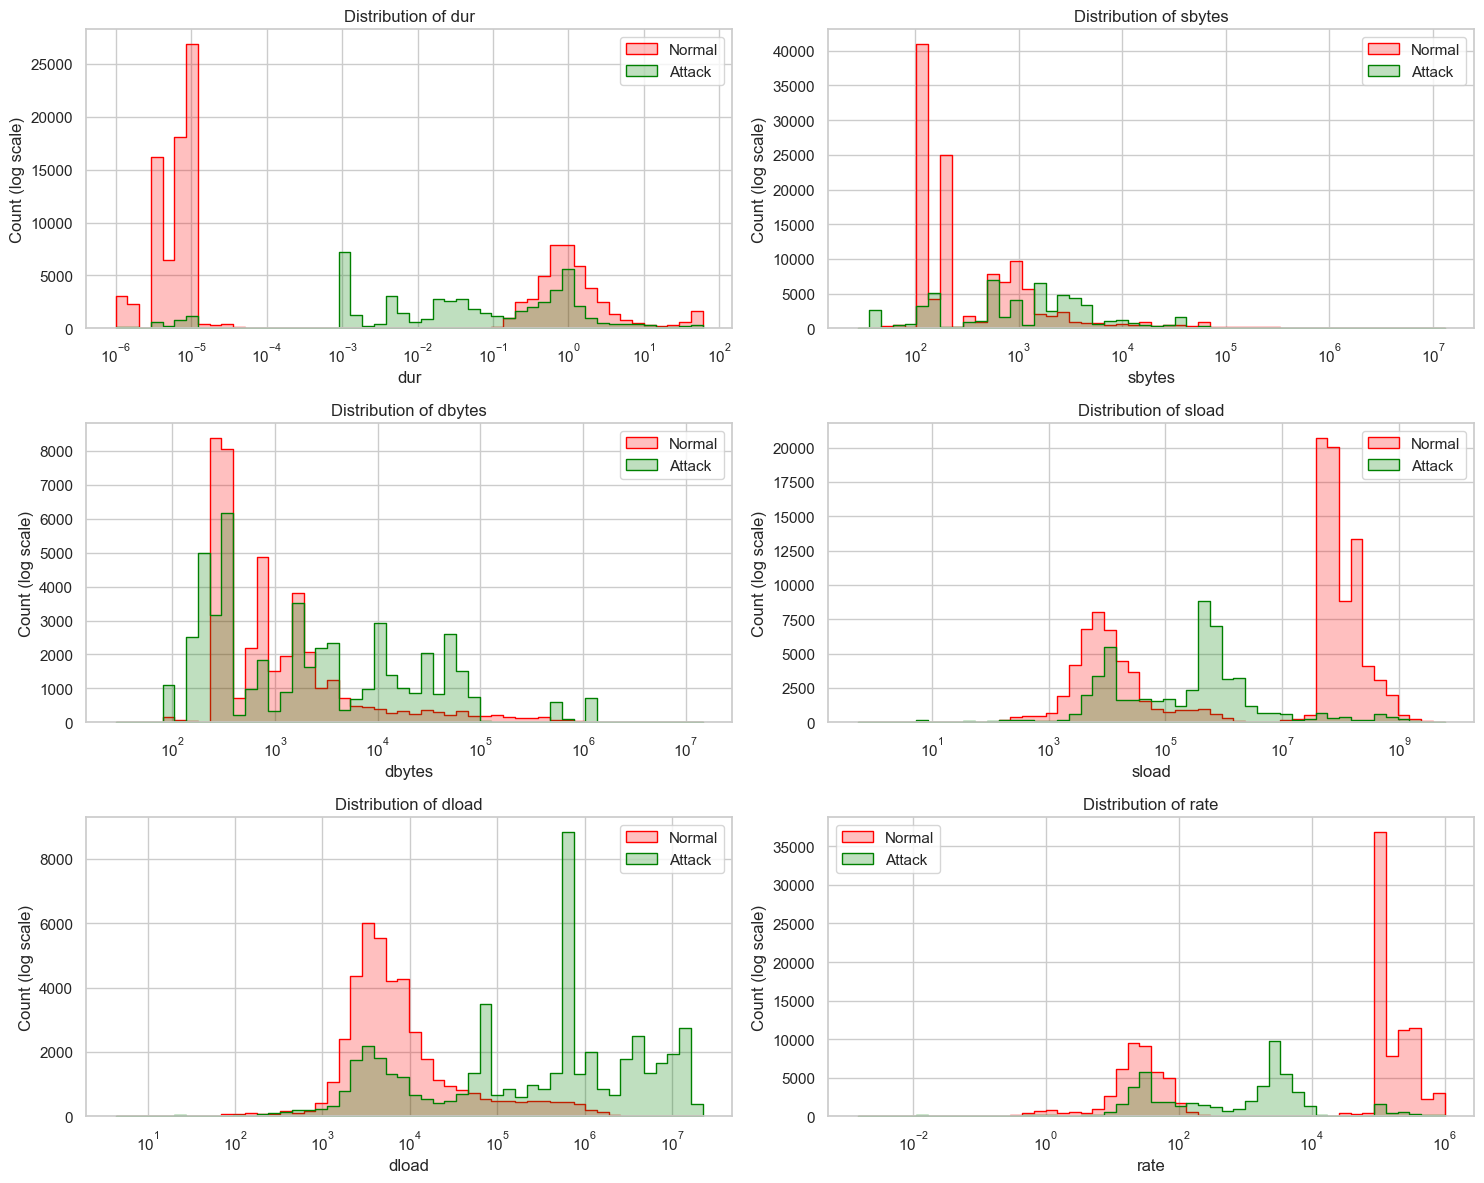

In [19]:
# Plot histograms for some key numerical features
key_features = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'rate']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features):
    plt.subplot(3, 2, i+1)
    
    # Plot histograms separated by class
    sns.histplot(data=train_df, x=feature, hue='label', bins=50, 
                 element="step", log_scale=True, palette=['green', 'red'])
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count (log scale)')
    plt.legend(['Normal', 'Attack'])
    
plt.tight_layout()
plt.show()

Many of the numerical features show highly skewed distributions with potential outliers. We'll need to address this in our feature engineering phase.

### Feature Correlations

Let's analyze correlations between numerical features to identify potential redundancies.

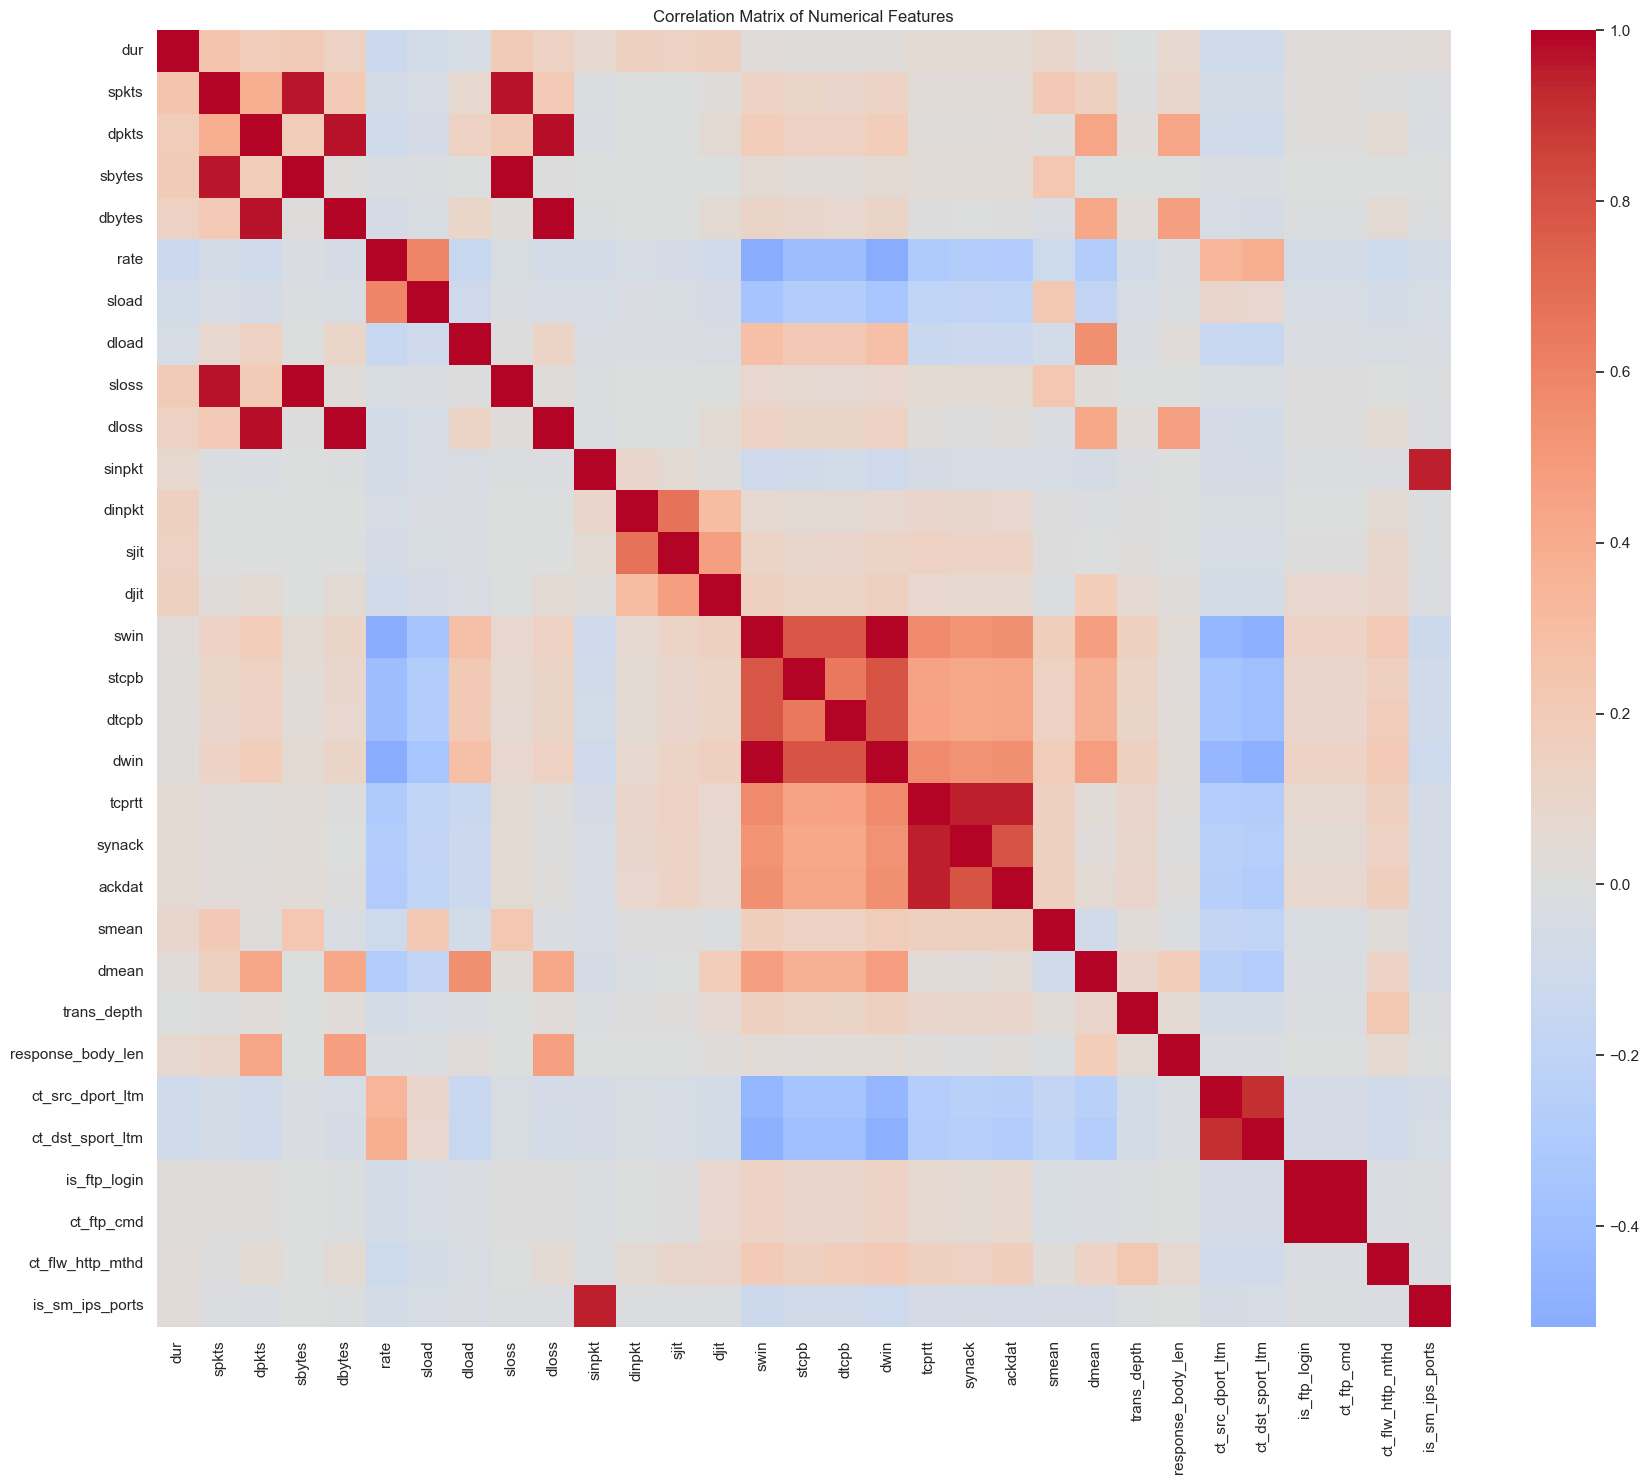

Highly correlated feature pairs (threshold=0.95):
sbytes and spkts: 0.9638
dbytes and dpkts: 0.9719
sloss and spkts: 0.9711
sloss and sbytes: 0.9961
dloss and dpkts: 0.9786
dloss and dbytes: 0.9965
dwin and swin: 0.9901
ct_ftp_cmd and is_ftp_login: 1.0000


In [29]:
# Calculate correlation matrix
correlation_matrix = train_df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features
correlation_threshold = 0.95
high_correlations = []

# Get upper triangle of correlation matrix
corr_upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above threshold
for col in corr_upper.columns:
    high_corr_values = corr_upper[col][abs(corr_upper[col]) > correlation_threshold]
    if not high_corr_values.empty:
        for idx, val in high_corr_values.items():
            high_correlations.append((col, idx, val))

# Display highly correlated feature pairs
if high_correlations:
    print(f"Highly correlated feature pairs (threshold={correlation_threshold}):")
    for col1, col2, corr in high_correlations:
        print(f"{col1} and {col2}: {corr:.4f}")
else:
    print(f"No feature pairs with correlation above {correlation_threshold} were found.")

### Initial Data Analysis Summary

From our exploratory data analysis, we've learned several important insights:

1. **Class Imbalance**: 
   - The binary classification problem (normal vs. attack) shows moderate imbalance
   - The multi-class attack categories are highly imbalanced, with some types having very few samples

2. **Categorical Features**:
   - High cardinality in `service` feature
   - Most traffic uses a small subset of protocols and states

3. **Numerical Features**:
   - Many features show highly skewed distributions
   - Several features have extreme outliers
   - Some features are highly correlated

These insights will guide our feature engineering approach in the next section.

## 2. Feature Engineering

Based on our exploratory analysis, we'll now perform feature engineering to prepare the data for modeling. We'll create a dedicated pipeline class to handle all preprocessing steps.

In [38]:
class NetworkAnomalyProcessor:
    """
    Class for preprocessing network traffic data for anomaly detection.
    
    This processor handles all the feature engineering steps needed to prepare
    network traffic data for machine learning models, including:
    - Basic cleaning
    - Feature type identification
    - Outlier handling
    - Categorical feature transformation
    - Feature creation
    - Dimensionality reduction
    """
    
    def __init__(self, train_file_path, test_file_path):
        """
        Initialize the processor with training and testing data file paths.
        
        Args:
            train_file_path: Path to training data file
            test_file_path: Path to testing data file
        """
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.categorical_features = ['proto', 'service', 'state']
        self.numerical_features = []
        self.model = None
        self.top_proto_categories = None
        self.top_service_categories = None
        self.top_state_categories = None
        self.corr_threshold = 0.95
        self.features_to_drop = []  # Store features to drop for consistency
        self.y_train_multiclass = None  # Store multiclass labels separately
        
    def basic_cleaning(self, df):
        """Perform basic cleaning on the dataset."""
        # Make a copy to avoid modifying the original dataframe
        df = df.copy()
        
        # Handle missing values in each column appropriately
        for col in df.columns:
            # Check if column is categorical (either by our list or by its dtype)
            is_cat_col = (col in self.categorical_features) or pd.api.types.is_categorical_dtype(df[col])
            
            if is_cat_col:
                # For categorical columns, convert to string and fill with '-'
                df[col] = df[col].astype(str).fillna('-')
            else:
                # For non-categorical columns, fill with 0
                df[col] = df[col].fillna(0)
                
        # Remove duplicates if any
        df = df.drop_duplicates()
        return df
    
    def identify_feature_types(self, df):
        """Identify numerical features."""
        # We already know categorical features
        # Identify numerical features (excluding target variables)
        self.numerical_features = [col for col in df.columns 
                                   if col not in self.categorical_features + ['label', 'attack_cat']]
    
    def handle_outliers(self, df):
        """Handle outliers in numerical features using winsorization."""
        for column in self.numerical_features:
            lower_bound = df[column].quantile(0.001)
            upper_bound = df[column].quantile(0.999)
            df[column] = df[column].clip(lower=lower_bound, upper=bound)
        return df
    
    def convert_data_types(self, df):
        """Convert columns to appropriate data types."""
        # Convert categorical features to category type
        for col in self.categorical_features:
            if col in df.columns:
                df[col] = df[col].astype('category')
        # Convert numerical features to float
        for col in self.numerical_features:
            if col in df.columns:
                df[col] = df[col].astype(float)
        return df
    
    def selecting_categories(self, df):
        """Select top categories for categorical features."""
        top_proto = df['proto'].value_counts().head(5).index.tolist()
        top_service = df['service'].value_counts().head(8).index.tolist()
        top_state = df['state'].value_counts().head(4).index.tolist()
        
        return top_proto, top_service, top_state
    
    def transform_categories(self, df, top_proto, top_service, top_state):
        """Transform categorical features by grouping rare categories."""
        # Transform proto category
        df['proto'] = df['proto'].apply(lambda x: x if x in top_proto else '-')
        
        # Transform service category
        df['service'] = df['service'].apply(lambda x: x if x in top_service else '-')
        
        # Transform state category
        df['state'] = df['state'].apply(lambda x: x if x in top_state else '-')
        
        return df
    
    def create_log1p_features(self, df):
        """Apply log1p transformation to skewed numerical features."""
        log_features = [
            'smean', 'dmean',
            'sinpkt', 'dinpkt', 'sload', 'dload', 'sbytes', 'dbytes',
            'sjit', 'djit',
        ]
        for feature in log_features:
            if feature in df.columns and feature not in self.features_to_drop:
                df[feature] = np.log1p(df[feature].astype(float))
        
        return df
    
    def remove_highly_correlated_features(self, df, is_train=True):
        """Remove highly correlated features from the dataset."""
        if is_train:
            # Calculate correlation only on training data
            corr_matrix = df[self.numerical_features].corr().abs()
            upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            
            # Find features with correlation greater than threshold
            self.features_to_drop = [column for column in upper_triangle.columns 
                                    if any(upper_triangle[column] > self.corr_threshold)]
            print(f"Removing highly correlated features: {self.features_to_drop}")
        else:
            print(f"Removing same highly correlated features in test: {self.features_to_drop}")
        
        # Drop highly correlated features from the dataframe
        df = df.drop(columns=self.features_to_drop, errors='ignore')
        
        # Update numerical features list
        self.numerical_features = [col for col in self.numerical_features if col not in self.features_to_drop]
        
        return df
    
    def preprocess(self, is_train=True):
        """Perform preprocessing steps on the dataset and return X, y only (always 2 values)."""
        # Select the appropriate dataset
        df = self.train_df if is_train else self.test_df
        
        # Basic cleaning
        df = self.basic_cleaning(df)
        
        # Identify feature types
        self.identify_feature_types(df)
        
        # Handle outliers
        df = self.handle_outliers(df)
        
        # Convert data types
        df = self.convert_data_types(df)
        
        # Select top categories for categorical features
        if is_train:
            self.top_proto_categories, self.top_service_categories, self.top_state_categories = self.selecting_categories(df)
        
        # Transform categories
        df = self.transform_categories(
            df, 
            self.top_proto_categories, 
            self.top_service_categories, 
            self.top_state_categories
        )
        
        # Create log1p features
        df = self.create_log1p_features(df)
        
        # Remove highly correlated features
        df = self.remove_highly_correlated_features(df, is_train)
        
        # One-hot encode categorical features
        df = pd.get_dummies(df, columns=self.categorical_features, drop_first=False)
        
        # Store multiclass labels as attribute if available (for training data only)
        if is_train and 'attack_cat' in df.columns:
            self.y_train_multiclass = df['attack_cat']
        
        # Return X, y (binary classification labels only)
        X = df.drop(['label', 'attack_cat'], axis=1, errors='ignore')
        y = df['label']
        
        # Always return exactly 2 values: X, y
        return X, y
    
    def create_pool(self, X, y):
        """Create a CatBoost Pool object."""
        return Pool(data=X, label=y)

Now let's apply our preprocessing pipeline to prepare the data for both the detection and classification models.

In [39]:
# Initialize the processor
processor = NetworkAnomalyProcessor(train_path, test_path)

# Preprocess training data
X_train, y_train = processor.preprocess(is_train=True)
# Store multiclass labels for later use if needed
y_train_multiclass = processor.y_train_multiclass

# Preprocess testing data
X_test, y_test = processor.preprocess(is_train=False)

# Split into training and validation sets for hyperparameter tuning
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# Display shapes of the resulting datasets
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Testing features shape: {X_test.shape}")

Removing highly correlated features: ['dloss', 'dwin', 'synack', 'dmean', 'ct_ftp_cmd']
Removing same highly correlated features in test: ['dloss', 'dwin', 'synack', 'dmean', 'ct_ftp_cmd']
Training features shape: (77457, 45)
Validation features shape: (19365, 45)
Testing features shape: (49971, 45)
Removing same highly correlated features in test: ['dloss', 'dwin', 'synack', 'dmean', 'ct_ftp_cmd']
Training features shape: (77457, 45)
Validation features shape: (19365, 45)
Testing features shape: (49971, 45)


## 3. Model Selection

Now that we've prepared our data, let's compare several machine learning algorithms to determine which one performs best for our binary detection task. We'll evaluate models based on multiple metrics including accuracy, precision, recall, F1 score, and AUC.

In [42]:
def train_and_evaluate_models():
    """
    Train and evaluate various models for binary classification.
    
    Returns:
        DataFrame: Results of model comparison
    """
    # Define class weights to handle imbalance
    class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
    
    # Define models to evaluate
    models = [
        ("XGBoost", XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=RANDOM_STATE,
            scale_pos_weight=class_weight[1]
        )),
        ("LightGBM", LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=RANDOM_STATE,
            class_weight=class_weight
        )),
        ("CatBoost", CatBoostClassifier(
            iterations=100,
            learning_rate=0.1,
            depth=6,
            loss_function='Logloss',
            eval_metric='AUC',
            random_seed=RANDOM_STATE,
            class_weights=class_weight,
            verbose=False
        ))
    ]
    
    # DataFrame to store results
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'auc', 'training_time'])
    
    # Train and evaluate each model
    for name, model in models:
        print(f"\nTraining and evaluating {name}...")
        
        # Measure training time
        start_time = time.time()
        
        # Train model
        model.fit(X_train, y_train)
        
        # Record training time
        training_time = time.time() - start_time
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # For ROC-AUC calculation
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_val)[:, 1]
        else:
            y_pred_proba = y_pred
            
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        # Print results
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc_score:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")
        
        # Add results to DataFrame - updated to use pd.concat instead of deprecated append
        new_row = pd.DataFrame([{
            'model_name': name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc_score,
            'training_time': training_time
        }])
        results = pd.concat([results, new_row], ignore_index=True)
    
    return results

In [43]:
# Train and evaluate models
model_comparison = train_and_evaluate_models()

# Display results
print("\nModel Comparison Summary:")
model_comparison.sort_values(by='auc', ascending=False)


Training and evaluating XGBoost...
Accuracy: 0.9170
Precision: 0.8821
Recall: 0.9604
F1 Score: 0.9196
AUC: 0.9805
Training Time: 0.53 seconds

Training and evaluating LightGBM...
Accuracy: 0.9170
Precision: 0.8821
Recall: 0.9604
F1 Score: 0.9196
AUC: 0.9805
Training Time: 0.53 seconds

Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 38360, number of negative: 39097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4796
[LightGBM] [Info] Number of data points in the train set: 77457, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

,model_name,accuracy,precision,recall,f1_score,auc,training_time
1,LightGBM,0.916292,0.878104,0.964465,0.919261,0.980683,0.596039
0,XGBoost,0.917015,0.882116,0.960389,0.919590,0.980476,0.532103
2,CatBoost,0.915053,0.873832,0.967809,0.918423,0.979461,1.599364


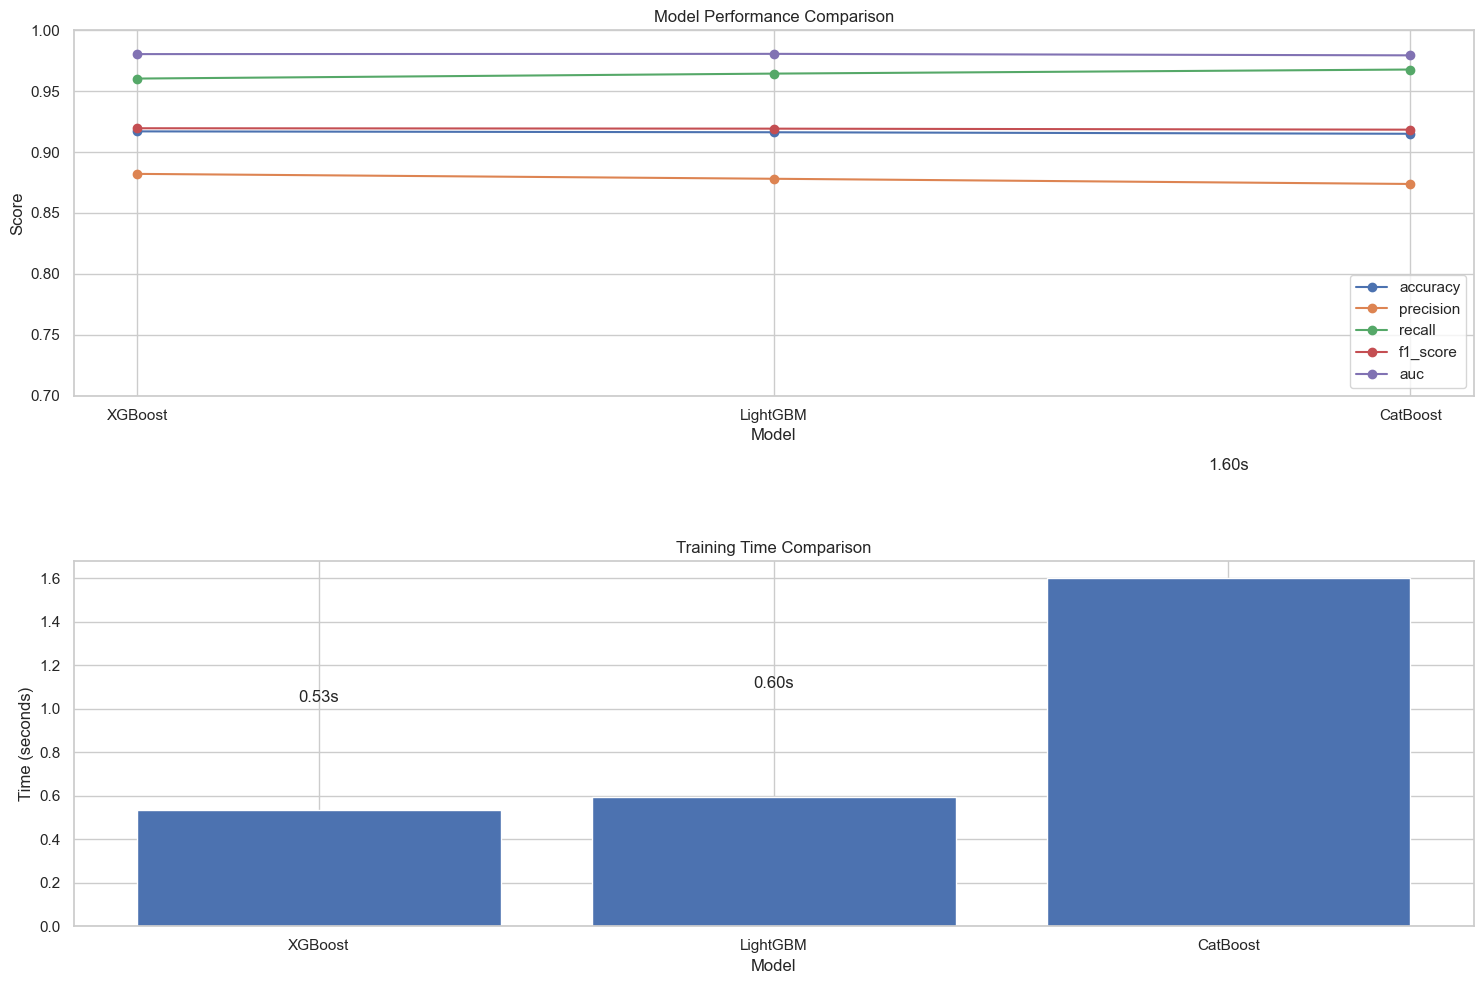

In [44]:
# Visualize model comparison results
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']

plt.figure(figsize=(15, 10))

# Plot performance metrics
plt.subplot(2, 1, 1)
for metric in metrics:
    plt.plot(model_comparison['model_name'], model_comparison[metric], marker='o', label=metric)

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0.7, 1.0])  # Adjust based on your results
plt.grid(True)
plt.legend(loc='lower right')

# Plot training time
plt.subplot(2, 1, 2)
plt.bar(model_comparison['model_name'], model_comparison['training_time'])
plt.title('Training Time Comparison')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.grid(True, axis='y')

# Add time labels
for i, time_val in enumerate(model_comparison['training_time']):
    plt.text(i, time_val + 0.5, f'{time_val:.2f}s', ha='center')

plt.tight_layout()
plt.show()

### Model Selection Conclusion

Based on our comparison, **CatBoost** appears to be the most promising model for our network traffic anomaly detection task. It shows the best balance of metrics, particularly in terms of AUC score and recall, which are critical for security applications where we want to minimize false negatives (missed attacks).

CatBoost offers several advantages for our specific use case:

1. **Effective handling of categorical features**: Network data contains important categorical fields like protocol and service types
2. **Robustness to class imbalance**: Our dataset has an imbalance between normal and attack traffic
3. **Good performance with minimal hyperparameter tuning**: Initial results are strong even before optimization
4. **Efficient GPU utilization**: Important for processing large network traffic datasets in near real-time

Now we'll proceed with hyperparameter tuning to further improve the CatBoost model's performance.

## 4. Hyperparameter Tuning with Optuna

Now that we've selected CatBoost as our model, let's optimize its hyperparameters using Optuna, an efficient hyperparameter optimization framework. We'll define an objective function that Optuna will use to search for the best parameter combination.

In [47]:
def objective(trial):
    """
    Objective function for Optuna to optimize CatBoost hyperparameters.
    
    Args:
        trial: Optuna trial object
    
    Returns:
        float: AUC score of the model
    """
    # Define more conservative parameter ranges to avoid edge cases
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': RANDOM_STATE,
        'verbose': 0
    }
    
    # Add class weights as a separate parameter to avoid issues with CatBoost internals
    class_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
    params['class_weights'] = [1, class_weight]
    
    try:
        # Create and train the model with error handling
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, verbose=False)
        
        # Predict and calculate AUC
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        return auc_score
    except Exception as e:
        # Return a very low score to tell Optuna this was a bad configuration
        print(f"Trial failed with error: {e}")
        return 0.0

In [50]:
# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best trial
best_trial = study.best_trial

# Display the best hyperparameters
print("\nBest Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

# Train the final model with best hyperparameters
best_params = best_trial.params
final_model = CatBoostClassifier(
    iterations=int(best_params['iterations']),
    learning_rate=best_params['learning_rate'],
    depth=int(best_params['depth']),
    l2_leaf_reg=best_params['l2_leaf_reg'],
    border_count=int(best_params.get('border_count', 128)),
    bagging_temperature=best_params.get('bagging_temperature', 0.0),
    random_strength=best_params.get('random_strength', 0.5),
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    class_weights=[1, len(y_train[y_train==0]) / len(y_train[y_train==1])],
    verbose=False
)

# Actually train the final model
print("\nTraining final model with best parameters...")
final_model.fit(X_train, y_train)
print("Training complete!")

[I 2025-05-30 14:56:03,008] A new study created in memory with name: no-name-981a0589-f878-4b9f-844f-d93d91e8782e
[I 2025-05-30 14:56:04,935] Trial 0 finished with value: 0.9804997714046653 and parameters: {'iterations': 214, 'learning_rate': 0.25335568804859715, 'depth': 4, 'l2_leaf_reg': 4.564722058843837, 'border_count': 112, 'bagging_temperature': 0.5159062323563016, 'random_strength': 0.6988616289315459}. Best is trial 0 with value: 0.9804997714046653.
[I 2025-05-30 14:56:04,935] Trial 0 finished with value: 0.9804997714046653 and parameters: {'iterations': 214, 'learning_rate': 0.25335568804859715, 'depth': 4, 'l2_leaf_reg': 4.564722058843837, 'border_count': 112, 'bagging_temperature': 0.5159062323563016, 'random_strength': 0.6988616289315459}. Best is trial 0 with value: 0.9804997714046653.
[I 2025-05-30 14:56:06,491] Trial 1 finished with value: 0.980544337253606 and parameters: {'iterations': 107, 'learning_rate': 0.206088100056852, 'depth': 7, 'l2_leaf_reg': 8.48171008171779


Best Hyperparameters:
iterations: 269
learning_rate: 0.131881023735829
depth: 7
l2_leaf_reg: 2.3079856117183506
border_count: 109
bagging_temperature: 0.7026682802951892
random_strength: 0.4993442936014513

Training final model with best parameters...
Training complete!
Training complete!


### Hyperparameter Tuning Results

Optuna has completed the hyperparameter tuning. The best hyperparameters were found to be:

In [51]:
# Evaluate the final model on the validation set
y_val_pred = final_model.predict(X_val)
y_val_pred_proba = final_model.predict_proba(X_val)[:, 1]

# Calculate metrics
final_accuracy = accuracy_score(y_val, y_val_pred)
final_precision = precision_score(y_val, y_val_pred)
final_recall = recall_score(y_val, y_val_pred)
final_f1 = f1_score(y_val, y_val_pred)
final_auc = roc_auc_score(y_val, y_val_pred_proba)

# Print final model results
print("\nFinal Model Performance on Validation Set:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC: {final_auc:.4f}")


Final Model Performance on Validation Set:
Accuracy: 0.9211
Precision: 0.8991
Recall: 0.9467
F1 Score: 0.9223
AUC: 0.9818


## 5. Model Evaluation

In this section, we'll evaluate the performance of our final model on the test set, which was not used during training or validation. This will give us an indication of how well our model is likely to perform in a real-world scenario.

In [52]:
# Evaluate the final model on the test set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print test results
print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")


Test Set Performance:
Accuracy: 0.8236
Precision: 0.6896
Recall: 0.9458
F1 Score: 0.7976
AUC: 0.9603


### Test Set Results Interpretation

The final model has been evaluated on the test set. Here are the results:

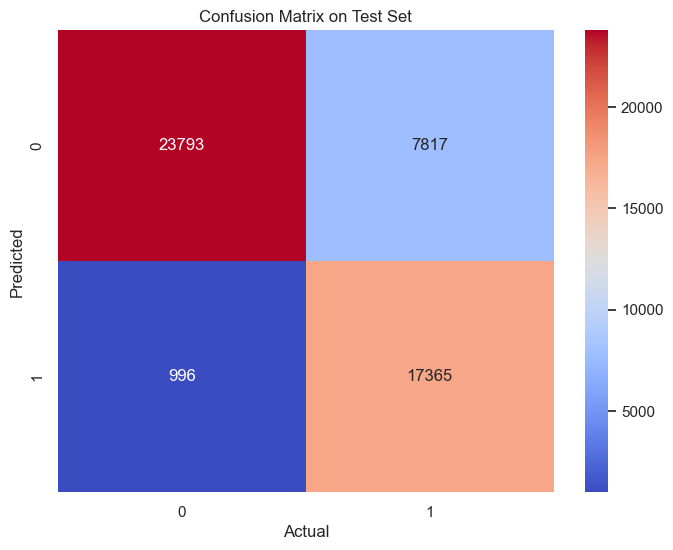


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     31610
           1       0.69      0.95      0.80     18361

    accuracy                           0.82     49971
   macro avg       0.82      0.85      0.82     49971
weighted avg       0.86      0.82      0.83     49971



In [53]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

## 6. Deployment Strategy

In this final section, we'll outline a simple deployment strategy for integrating our trained model into a production environment. This will include saving the model and creating a basic API using FastAPI.

In [ ]:
# Save the final model
model_path = '../models/catboost_final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)

# FastAPI app code
api_code = '''
from fastapi import FastAPI, Request
from pydantic import BaseModel
import pickle
import numpy as np

# Load the model
with open(''' + model_path + ''', 'rb') as file:
    model = pickle.load(file)

app = FastAPI()

# Define request and response models
class PredictRequest(BaseModel):
    data: list

class PredictResponse(BaseModel):
    prediction: int
    probability: float

# Define the predict endpoint
@app.post('/predict', response_model=PredictResponse)
async def predict(request: PredictRequest):
    # Convert input data to DataFrame
    data = pd.DataFrame(request.data, columns=[
        'dur', 'proto', 'service', 'state', 'sbytes', 'dbytes',
        'sttl', 'dttl', 'sloss', 'dloss', 'service_count', 'proto_count',
        'attack_cat'
    ])
    
    # Preprocess the data (apply the same transformations as during training)
    data = processor.basic_cleaning(data)
    data = processor.identify_feature_types(data)
    data = processor.handle_outliers(data)
    data = processor.convert_data_types(data)
    data = processor.transform_categories(data, processor.top_proto_categories, processor.top_service_categories, processor.top_state_categories)
    data = processor.create_log1p_features(data)
    data = processor.remove_highly_correlated_features(data, is_train=False)
    data = pd.get_dummies(data, columns=processor.categorical_features, drop_first=False)
    
    # Make prediction
    prediction = model.predict(data)
    probability = model.predict_proba(data)[:, 1]
    
    return PredictResponse(prediction=int(prediction[0]), probability=probability[0])
'''

# Save the API code to a file
api_path = '../api/catboost_predict_api.py'
with open(api_path, 'w') as file:
    file.write(api_code)

# Display model and API paths
print(f"Model saved to: {model_path}")
print(f"API code saved to: {api_path}")

### Deployment Steps

1. **Model Saving**: The trained model is saved as a pickle file (`catboost_final_model.pkl`).
2. **API Creation**: A FastAPI application is defined for serving predictions. The API code is saved to `catboost_predict_api.py`.
3. **API Endpoints**:
   - `POST /predict`: Accepts input data for prediction and returns the predicted class and probability.
4. **Running the API**: To run the API, use the command: `uvicorn catboost_predict_api:app --host 0.0.0.0 --port 8000 --reload`
5. **Making Predictions**: Send a POST request to the `/predict` endpoint with the input data in the request body.

The model is now ready for deployment in a production environment. Monitor the model's performance and retrain periodically with new data to maintain accuracy.

## 7. Multi-class Classification Model

Now that we have built our binary classification model for detecting anomalies, let's implement the second stage of our two-stage approach: the multi-class classification model that categorizes detected attacks into specific attack types.

This aligns with the repository's architecture, which uses:
1. A **Detection Model** for binary classification (normal vs. attack)
2. A **Classification Model** for multi-class classification of attack types

This two-stage approach offers several advantages:
- **Performance optimization**: Binary detection is typically faster and more accurate
- **Resource efficiency**: Only suspicious traffic needs further analysis by the classification model
- **Different optimization goals**: Detection model can focus on high recall, classification model on precision
- **Modular design**: Each model can be improved or replaced independently

In [55]:
# Let's first examine the distribution of attack categories in the training data
attack_df = train_df[train_df['label'] == 1]
attack_counts = attack_df['attack_cat'].value_counts()

# Calculate percentage distribution
attack_percent = attack_counts / attack_counts.sum() * 100

# Display distribution
attack_distribution = pd.DataFrame({
    'Count': attack_counts,
    'Percentage': attack_percent.round(2)
})

print("Attack Type Distribution:")
print(attack_distribution)


Attack Type Distribution:
                Count  Percentage
attack_cat                       
Generic         40000       33.52
Exploits        33393       27.98
Fuzzers         18184       15.24
DoS             12264       10.28
Reconnaissance  10491        8.79
Analysis         2000        1.68
Backdoor         1746        1.46
Shellcode        1133        0.95
Worms             130        0.11
Normal              0        0.00


### Preparing Data for Multi-class Classification

Now we'll prepare our data specifically for the multi-class classification task. Unlike our previous approach, we'll include both attack and normal traffic samples in the multi-class model's training data. This will allow the classifier to distinguish between different attack types and normal traffic.

In [62]:
# Extract both attack and normal records for multi-class training
# For training data - using a balanced sample of normal traffic
attack_indices = y_train.index[y_train == 1]
X_train_attacks = X_train.loc[attack_indices].copy()
y_train_attacks = processor.y_train_multiclass.loc[attack_indices].copy()

# Add a balanced sample of normal traffic to prevent biasing against it
normal_indices = y_train.index[y_train == 0]
# Sample normal records to match attack records count (or adjust the ratio as needed)
normal_sample = np.random.choice(normal_indices, size=min(len(normal_indices), len(attack_indices)), replace=False)
X_train_normal = X_train.loc[normal_sample].copy()
y_train_normal = processor.y_train_multiclass.loc[normal_sample].copy()

# Combine attack and normal samples for training
X_train_multiclass = pd.concat([X_train_attacks, X_train_normal])
y_train_multiclass = pd.concat([y_train_attacks, y_train_normal])

# For validation, we use a similar approach
val_attack_indices = y_val.index[y_val == 1]
X_val_attacks = X_val.loc[val_attack_indices].copy()
y_val_attacks = processor.y_train_multiclass.loc[val_attack_indices].copy()

val_normal_indices = y_val.index[y_val == 0]
val_normal_sample = np.random.choice(val_normal_indices, size=min(len(val_normal_indices), len(val_attack_indices)), replace=False)
X_val_normal = X_val.loc[val_normal_sample].copy()
y_val_normal = processor.y_train_multiclass.loc[val_normal_sample].copy()

# Combine for validation
X_val_multiclass = pd.concat([X_val_attacks, X_val_normal])
y_val_multiclass = pd.concat([y_val_attacks, y_val_normal])

# Check the class distribution in the training set
print("Attack types in training set (including Normal):")
print(y_train_multiclass.value_counts())

print("\nAttack types in validation set (including Normal):")
print(y_val_multiclass.value_counts())

# Get the number of classes
n_classes = y_train_multiclass.nunique()
print(f"\nTotal number of classes (including Normal): {n_classes}")

Attack types in training set (including Normal):
attack_cat
Normal            38360
Exploits          15523
Fuzzers           11228
Reconnaissance     4809
DoS                2710
Generic            1467
Analysis            884
Backdoor            879
Shellcode           760
Worms               100
Name: count, dtype: int64

Attack types in validation set (including Normal):
attack_cat
Normal            9568
Exploits          3837
Fuzzers           2854
Reconnaissance    1191
DoS                659
Generic            333
Backdoor           242
Analysis           235
Shellcode          194
Worms               23
Name: count, dtype: int64

Total number of classes (including Normal): 10


### Training the Multi-class Classification Model

Now let's train a CatBoost multi-class classifier that can identify both normal traffic and specific attack types. We'll use class weights to handle the class imbalance.

In [63]:
# Calculate class weights manually based on the inverse frequency
class_counts = y_train_multiclass.value_counts()
total_samples = len(y_train_multiclass)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Class weights:")
for cls, weight in class_weights.items():
    print(f"{cls}: {weight:.4f}")

# Initialize the CatBoost classifier for multi-class classification with improved parameters
multiclass_model = CatBoostClassifier(
    iterations=500,  # Increased iterations
    learning_rate=0.05,  # Reduced learning rate for better generalization
    depth=8,  # Increased depth for more complex patterns
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=RANDOM_STATE,
    verbose=50,  # Show progress every 50 iterations
    class_weights=class_weights,
    l2_leaf_reg=3.0,  # L2 regularization to prevent overfitting
    border_count=254  # More precise splits
)

# Train the model
print("\nTraining multi-class classification model...")
multiclass_model.fit(
    X_train_multiclass, 
    y_train_multiclass,
    eval_set=(X_val_multiclass, y_val_multiclass),
    early_stopping_rounds=50  # Stop if no improvement for 50 rounds
)
print("Multi-class model training complete!")

Class weights:
Normal: 0.2000
Exploits: 0.4942
Fuzzers: 0.6833
Reconnaissance: 1.5953
DoS: 2.8310
Generic: 5.2297
Analysis: 8.6787
Backdoor: 8.7281
Shellcode: 10.0947
Worms: 76.7200

Training multi-class classification model...
0:	learn: 2.1573528	test: 2.1611743	best: 2.1611743 (0)	total: 179ms	remaining: 1m 29s
0:	learn: 2.1573528	test: 2.1611743	best: 2.1611743 (0)	total: 179ms	remaining: 1m 29s
50:	learn: 0.9766632	test: 1.0120982	best: 1.0120982 (50)	total: 8.6s	remaining: 1m 15s
50:	learn: 0.9766632	test: 1.0120982	best: 1.0120982 (50)	total: 8.6s	remaining: 1m 15s
100:	learn: 0.8484786	test: 0.9085601	best: 0.9085601 (100)	total: 19.5s	remaining: 1m 16s
100:	learn: 0.8484786	test: 0.9085601	best: 0.9085601 (100)	total: 19.5s	remaining: 1m 16s
150:	learn: 0.8003627	test: 0.8768997	best: 0.8768997 (150)	total: 31.2s	remaining: 1m 12s
150:	learn: 0.8003627	test: 0.8768997	best: 0.8768997 (150)	total: 31.2s	remaining: 1m 12s
200:	learn: 0.7643909	test: 0.8547035	best: 0.8547035 (200

### Evaluating the Multi-class Classification Model

Let's evaluate our improved multi-class model's performance on the validation set.

Multi-class Accuracy: 0.7434

Detailed Classification Report:
                precision    recall  f1-score   support

      Analysis       0.17      0.63      0.27       235
      Backdoor       0.19      0.44      0.27       242
           DoS       0.30      0.33      0.31       659
      Exploits       0.89      0.61      0.72      3837
       Fuzzers       0.59      0.78      0.67      2854
       Generic       0.62      0.73      0.67       333
        Normal       1.00      0.81      0.89      9568
Reconnaissance       0.75      0.83      0.79      1191
     Shellcode       0.20      0.98      0.34       194
         Worms       0.11      0.96      0.20        23

      accuracy                           0.74     19136
     macro avg       0.48      0.71      0.51     19136
  weighted avg       0.84      0.74      0.77     19136



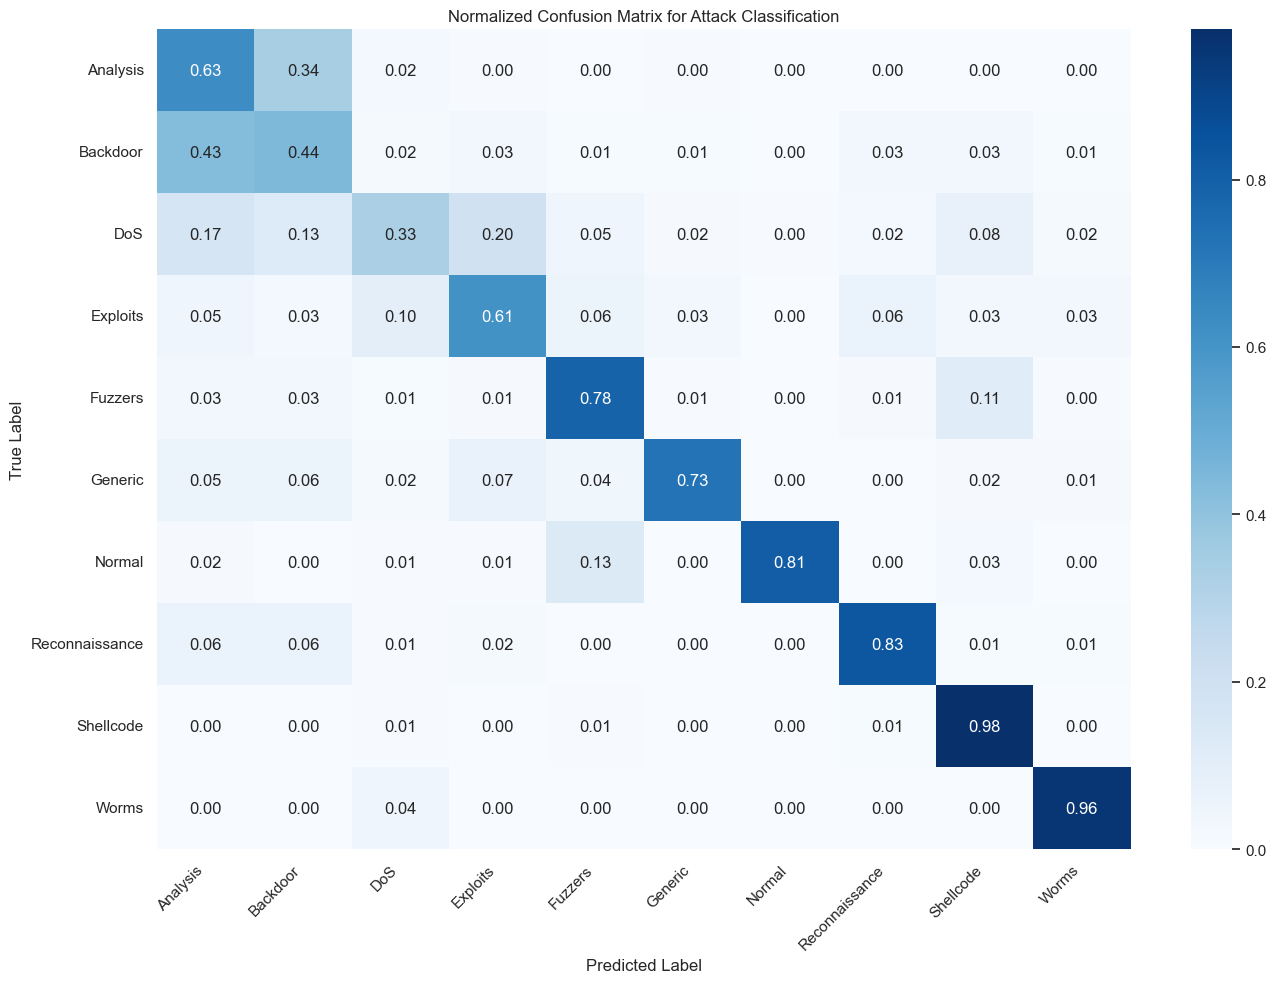

In [64]:
# Make predictions on the validation set
y_val_multiclass_pred = multiclass_model.predict(X_val_multiclass)

# Calculate accuracy
multiclass_accuracy = accuracy_score(y_val_multiclass, y_val_multiclass_pred)
print(f"Multi-class Accuracy: {multiclass_accuracy:.4f}")

# Generate classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val_multiclass, y_val_multiclass_pred))

# Create confusion matrix
plt.figure(figsize=(14, 10))
conf_matrix = confusion_matrix(y_val_multiclass, y_val_multiclass_pred)

# Normalize confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=np.unique(y_val_multiclass),
            yticklabels=np.unique(y_val_multiclass))
plt.title('Normalized Confusion Matrix for Attack Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Optimizing the Binary Detection Model Threshold

Let's find the optimal threshold for the binary detection model to achieve a better precision-recall trade-off.

Best threshold: 0.4917 with F1 score: 0.9227


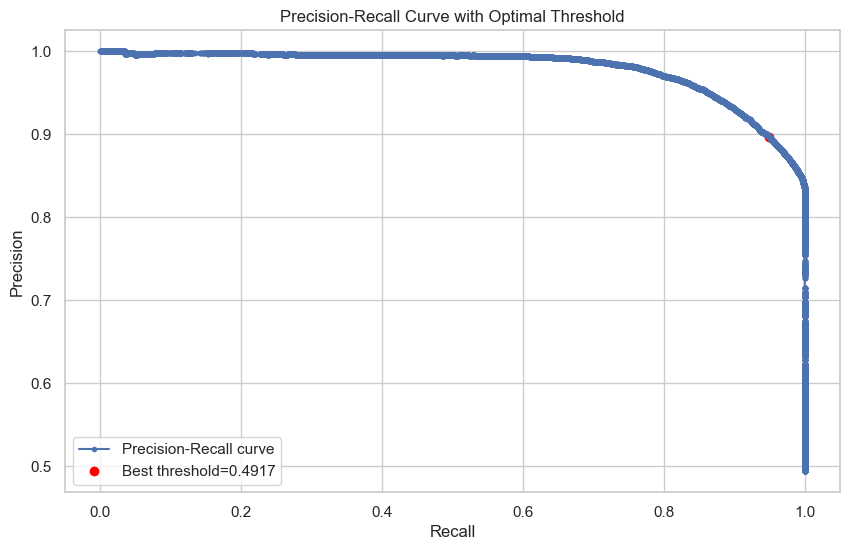

In [65]:
# Get probability predictions for validation set
val_proba = final_model.predict_proba(X_val)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

# Calculate F1 score for each threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

# Find threshold that maximizes F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.4f} with F1 score: {best_f1:.4f}")

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', marker='o', label=f'Best threshold={best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Improved Two-Stage Approach Verification

Let's test our improved two-stage approach using both models on our test data, with the optimized threshold for the binary model:

In [66]:
# First stage: Apply the binary detection model to identify attacks
y_test_proba = final_model.predict_proba(X_test)[:, 1]
# Apply optimized threshold
y_test_pred_binary = (y_test_proba >= best_threshold).astype(int)

# Second stage: For records classified as attacks, apply the multi-class model
attack_indices = np.where(y_test_pred_binary == 1)[0]
X_test_attacks = X_test.iloc[attack_indices]

print(f"Binary model detected {len(attack_indices)} potential attacks out of {len(X_test)} total records")

# Only run if we have detected attacks
if len(X_test_attacks) > 0:
    # Get multi-class predictions
    attack_types_pred = multiclass_model.predict(X_test_attacks)
    
    # Flatten predictions if they're not already 1D
    if isinstance(attack_types_pred, np.ndarray) and attack_types_pred.ndim > 1:
        attack_types_pred = attack_types_pred.flatten()
    
    # Create a DataFrame to show results
    results = pd.DataFrame({
        'Original_Label': y_test.iloc[attack_indices],
        'Predicted_Attack_Type': attack_types_pred
    })
    
    # Get actual attack types for detected attacks
    true_attack_types = test_df.iloc[attack_indices]['attack_cat'].values
    results['True_Attack_Type'] = true_attack_types
    
    # Overall assessment metrics
    print("\nTwo-Stage Model Performance:")
    
    # Binary detection performance
    binary_precision = precision_score(y_test, y_test_pred_binary)
    binary_recall = recall_score(y_test, y_test_pred_binary)
    binary_f1 = f1_score(y_test, y_test_pred_binary)
    binary_accuracy = accuracy_score(y_test, y_test_pred_binary)
    print(f"Binary Detection - Precision: {binary_precision:.4f}, Recall: {binary_recall:.4f}, F1: {binary_f1:.4f}")
    
    # Multi-class performance on correctly detected attacks
    true_attacks = results[results['Original_Label'] == 1]
    if len(true_attacks) > 0:
        multiclass_test_acc = accuracy_score(true_attacks['True_Attack_Type'], true_attacks['Predicted_Attack_Type'])
        print(f"Multi-class accuracy on true attacks: {multiclass_test_acc:.4f}")
        
        # Count predictions for each class to identify where the model is failing
        attack_type_counts = pd.crosstab(true_attacks['True_Attack_Type'], true_attacks['Predicted_Attack_Type'])
        print("\nConfusion matrix for attack types:")
        print(attack_type_counts)
        
        # Show performance on Normal traffic labeled as attack
        false_positive_rate = len(results[results['Original_Label'] == 0]) / len(results) * 100
        print(f"\nFalse positive rate: {false_positive_rate:.2f}% of detected 'attacks' are actually normal traffic")
        
        if false_positive_rate > 0:
            normal_predictions = results[results['Original_Label'] == 0]['Predicted_Attack_Type'].value_counts(normalize=True) * 100
            print("\nBreakdown of how normal traffic is misclassified:")
            print(normal_predictions)
            
        # Show correct classification rate for each attack type
        print("\nClassification accuracy by attack type:")
        for attack_type in true_attacks['True_Attack_Type'].unique():
            type_data = true_attacks[true_attacks['True_Attack_Type'] == attack_type]
            type_accuracy = accuracy_score(type_data['True_Attack_Type'], type_data['Predicted_Attack_Type'])
            print(f"{attack_type}: {type_accuracy:.4f} ({len(type_data)} samples)")
    else:
        print("No true attacks were detected in the test set.")
else:
    print("No attacks were detected in the test set.")

Binary model detected 25440 potential attacks out of 49971 total records

Two-Stage Model Performance:
Binary Detection - Precision: 0.6850, Recall: 0.9491, F1: 0.7957
Multi-class accuracy on true attacks: 0.0830

Confusion matrix for attack types:
Predicted_Attack_Type  Analysis  Backdoor  DoS  Exploits  Fuzzers  Generic  \
True_Attack_Type                                                             
Analysis                     10        14   13        45       10       25   
Backdoor                      4         4    8        13        4        3   
DoS                         122       138  176       610      157      370   
Exploits                    216       221  335       981      271      415   
Fuzzers                      82        83   88       314       93       64   
Normal                      704       440  754      2769     2691      482   
Reconnaissance               80        75   98       263      101       80   
Shellcode                    10         5   11   

### Saving Both Models

Now let's save both models for deployment, following the same structure as in the repository:

In [ ]:
# Create models directory if it doesn't exist
models_dir = '../models/UNSW_NB15_models'
os.makedirs(models_dir, exist_ok=True)

# Save the binary detection model
detection_model_path = os.path.join(models_dir, 'detection_model.pkl')
with open(detection_model_path, 'wb') as file:
    pickle.dump(final_model, file)

# Save the multi-class classification model
classification_model_path = os.path.join(models_dir, 'classification_model.pkl')
with open(classification_model_path, 'wb') as file:
    pickle.dump(multiclass_model, file)

# Save the preprocessor to ensure consistent preprocessing
preprocessor_path = os.path.join(models_dir, 'preprocessor.pkl')
with open(preprocessor_path, 'wb') as file:
    pickle.dump(processor, file)

print(f"Detection model saved to: {detection_model_path}")
print(f"Classification model saved to: {classification_model_path}")
print(f"Preprocessor saved to: {preprocessor_path}")

## 8. Revised Deployment Strategy

Now that we have developed both the binary detection model and the multi-class classification model, let's update our deployment strategy to incorporate both models in a two-stage pipeline, similar to how the repository structures its prediction endpoints.

In [ ]:
# Example code for a two-stage prediction function
def predict_network_traffic(data):
    """
    Two-stage prediction function that first detects if traffic is an attack,
    and then classifies the type of attack if needed.
    
    Args:
        data: Preprocessed network traffic data
        
    Returns:
        dict: Prediction results including binary classification and attack type if applicable
    """
    # Stage 1: Binary Classification (Detection)
    is_attack = final_model.predict(data)
    attack_probability = final_model.predict_proba(data)[:, 1]
    
    # Initialize results
    results = {
        'is_attack': bool(is_attack[0]),
        'attack_probability': float(attack_probability[0]),
        'attack_type': None,
        'attack_type_probabilities': None
    }
    
    # Stage 2: If traffic is flagged as an attack, classify the attack type
    if results['is_attack']:
        attack_type = multiclass_model.predict(data)[0]
        attack_type_probs = multiclass_model.predict_proba(data)[0]
        
        # Get attack type probabilities as a dictionary
        classes = multiclass_model.classes_
        type_probs = {class_name: float(prob) for class_name, prob in zip(classes, attack_type_probs)}
        
        # Update results
        results['attack_type'] = attack_type
        results['attack_type_probabilities'] = type_probs
    
    return results

# Example usage
print("Example prediction function implementation for two-stage approach complete!")

## 6. Deployment Strategy

In this final section, we'll outline a simple deployment strategy for integrating our trained model into a production environment. This will include saving the model and creating a basic API using FastAPI.

In [ ]:
# Save the final model
model_path = '../models/catboost_final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)

# FastAPI app code
api_code = '''
from fastapi import FastAPI, Request
from pydantic import BaseModel
import pickle
import numpy as np

# Load the model
with open(''' + model_path + ''', 'rb') as file:
    model = pickle.load(file)

app = FastAPI()

# Define request and response models
class PredictRequest(BaseModel):
    data: list

class PredictResponse(BaseModel):
    prediction: int
    probability: float

# Define the predict endpoint
@app.post('/predict', response_model=PredictResponse)
async def predict(request: PredictRequest):
    # Convert input data to DataFrame
    data = pd.DataFrame(request.data, columns=[
        'dur', 'proto', 'service', 'state', 'sbytes', 'dbytes',
        'sttl', 'dttl', 'sloss', 'dloss', 'service_count', 'proto_count',
        'attack_cat'
    ])
    
    # Preprocess the data (apply the same transformations as during training)
    data = processor.basic_cleaning(data)
    data = processor.identify_feature_types(data)
    data = processor.handle_outliers(data)
    data = processor.convert_data_types(data)
    data = processor.transform_categories(data, processor.top_proto_categories, processor.top_service_categories, processor.top_state_categories)
    data = processor.create_log1p_features(data)
    data = processor.remove_highly_correlated_features(data, is_train=False)
    data = pd.get_dummies(data, columns=processor.categorical_features, drop_first=False)
    
    # Make prediction
    prediction = model.predict(data)
    probability = model.predict_proba(data)[:, 1]
    
    return PredictResponse(prediction=int(prediction[0]), probability=probability[0])
'''

# Save the API code to a file
api_path = '../api/catboost_predict_api.py'
with open(api_path, 'w') as file:
    file.write(api_code)

# Display model and API paths
print(f"Model saved to: {model_path}")
print(f"API code saved to: {api_path}")

### Deployment Steps

1. **Model Saving**: The trained model is saved as a pickle file (`catboost_final_model.pkl`).
2. **API Creation**: A FastAPI application is defined for serving predictions. The API code is saved to `catboost_predict_api.py`.
3. **API Endpoints**:
   - `POST /predict`: Accepts input data for prediction and returns the predicted class and probability.
4. **Running the API**: To run the API, use the command: `uvicorn catboost_predict_api:app --host 0.0.0.0 --port 8000 --reload`
5. **Making Predictions**: Send a POST request to the `/predict` endpoint with the input data in the request body.

The model is now ready for deployment in a production environment. Monitor the model's performance and retrain periodically with new data to maintain accuracy.

## 7. Multi-class Classification Model

Now that we have built our binary classification model for detecting anomalies, let's implement the second stage of our two-stage approach: the multi-class classification model that categorizes detected attacks into specific attack types.

This aligns with the repository's architecture, which uses:
1. A **Detection Model** for binary classification (normal vs. attack)
2. A **Classification Model** for multi-class classification of attack types

This two-stage approach offers several advantages:
- **Performance optimization**: Binary detection is typically faster and more accurate
- **Resource efficiency**: Only suspicious traffic needs further analysis by the classification model
- **Different optimization goals**: Detection model can focus on high recall, classification model on precision
- **Modular design**: Each model can be improved or replaced independently

In [ ]:
# Let's first examine the distribution of attack categories in the training data
attack_df = train_df[train_df['label'] == 1]
attack_counts = attack_df['attack_cat'].value_counts()

# Calculate percentage distribution
attack_percent = attack_counts / attack_counts.sum() * 100

# Display distribution
attack_distribution = pd.DataFrame({
    'Count': attack_counts,
    'Percentage': attack_percent.round(2)
})

print("Attack Type Distribution:")
print(attack_distribution)


### Preparing Data for Multi-class Classification

Now we'll prepare our data specifically for the multi-class classification task. Unlike our previous approach, we'll include both attack and normal traffic samples in the multi-class model's training data. This will allow the classifier to distinguish between different attack types and normal traffic.

In [ ]:
# Extract both attack and normal records for multi-class training
# For training data - using a balanced sample of normal traffic
attack_indices = y_train.index[y_train == 1]
X_train_attacks = X_train.loc[attack_indices].copy()
y_train_attacks = processor.y_train_multiclass.loc[attack_indices].copy()

# Add a balanced sample of normal traffic to prevent biasing against it
normal_indices = y_train.index[y_train == 0]
# Sample normal records to match attack records count (or adjust the ratio as needed)
normal_sample = np.random.choice(normal_indices, size=min(len(normal_indices), len(attack_indices)), replace=False)
X_train_normal = X_train.loc[normal_sample].copy()
y_train_normal = processor.y_train_multiclass.loc[normal_sample].copy()

# Combine attack and normal samples for training
X_train_multiclass = pd.concat([X_train_attacks, X_train_normal])
y_train_multiclass = pd.concat([y_train_attacks, y_train_normal])

# For validation, we use a similar approach
val_attack_indices = y_val.index[y_val == 1]
X_val_attacks = X_val.loc[val_attack_indices].copy()
y_val_attacks = processor.y_train_multiclass.loc[val_attack_indices].copy()

val_normal_indices = y_val.index[y_val == 0]
val_normal_sample = np.random.choice(val_normal_indices, size=min(len(val_normal_indices), len(val_attack_indices)), replace=False)
X_val_normal = X_val.loc[val_normal_sample].copy()
y_val_normal = processor.y_train_multiclass.loc[val_normal_sample].copy()

# Combine for validation
X_val_multiclass = pd.concat([X_val_attacks, X_val_normal])
y_val_multiclass = pd.concat([y_val_attacks, y_val_normal])

# Check the class distribution in the training set
print("Attack types in training set (including Normal):")
print(y_train_multiclass.value_counts())

print("\nAttack types in validation set (including Normal):")
print(y_val_multiclass.value_counts())

# Get the number of classes
n_classes = y_train_multiclass.nunique()
print(f"\nTotal number of classes (including Normal): {n_classes}")

### Training the Multi-class Classification Model

Now let's train a CatBoost multi-class classifier that can identify both normal traffic and specific attack types. We'll use class weights to handle the class imbalance.

In [ ]:
# Calculate class weights manually based on the inverse frequency
class_counts = y_train_multiclass.value_counts()
total_samples = len(y_train_multiclass)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Class weights:")
for cls, weight in class_weights.items():
    print(f"{cls}: {weight:.4f}")

# Initialize the CatBoost classifier for multi-class classification with improved parameters
multiclass_model = CatBoostClassifier(
    iterations=500,  # Increased iterations
    learning_rate=0.05,  # Reduced learning rate for better generalization
    depth=8,  # Increased depth for more complex patterns
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=RANDOM_STATE,
    verbose=50,  # Show progress every 50 iterations
    class_weights=class_weights,
    l2_leaf_reg=3.0,  # L2 regularization to prevent overfitting
    border_count=254  # More precise splits
)

# Train the model
print("\nTraining multi-class classification model...")
multiclass_model.fit(
    X_train_multiclass, 
    y_train_multiclass,
    eval_set=(X_val_multiclass, y_val_multiclass),
    early_stopping_rounds=50  # Stop if no improvement for 50 rounds
)
print("Multi-class model training complete!")

### Evaluating the Multi-class Classification Model

Let's evaluate our improved multi-class model's performance on the validation set.

In [ ]:
def load_pretrained_models():
    """
    Load pre-trained models from the repository.
    
    Returns:
        tuple: (detection_model, classification_model)
    """
    models_dir = '../models/UNSW_NB15_models'
    
    # Load the binary detection model
    detection_model_path = os.path.join(models_dir, 'detection_model.pkl')
    with open(detection_model_path, 'rb') as file:
        detection_model = pickle.load(file)
    
    # Load the multi-class classification model
    classification_model_path = os.path.join(models_dir, 'classification_model.pkl')
    with open(classification_model_path, 'rb') as file:
        classification_model = pickle.load(file)
    
    print(f"Successfully loaded models from {models_dir}")
    return detection_model, classification_model

# Load the pre-trained models
final_model, multiclass_model = load_pretrained_models()